#**Initial Setup**

In [ ]:
!nvidia-smi

Tue Apr  5 09:54:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
 from google.colab import drive

 drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extracting the dataset into the drive

import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Face_Physiognomy/FER_Dataset_NDF.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Face_Physiognomy/')

In [ ]:
# Importing all the required libraries

!pip install livelossplot

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import os

import tensorflow as tf
from tensorflow import keras
from livelossplot import PlotLossesKerasTF
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


     |████████████████████████████████| 793 kB 5.9 MB/s 
     |████████████████████████████████| 381 kB 26.8 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.32.0 which is incompatible.


#**Exploring Data**

In [ ]:
#Defining the Parameters and Hyperparameters

EXPRESSION = 'angry'
FOLDER_PATH = "/content/drive/MyDrive/Face_Physiognomy/images/"

PICTURE_SIZE = 48
BATCH_SIZE  = 64
NO_OF_CLASSES = 5
EPOCHS = 50

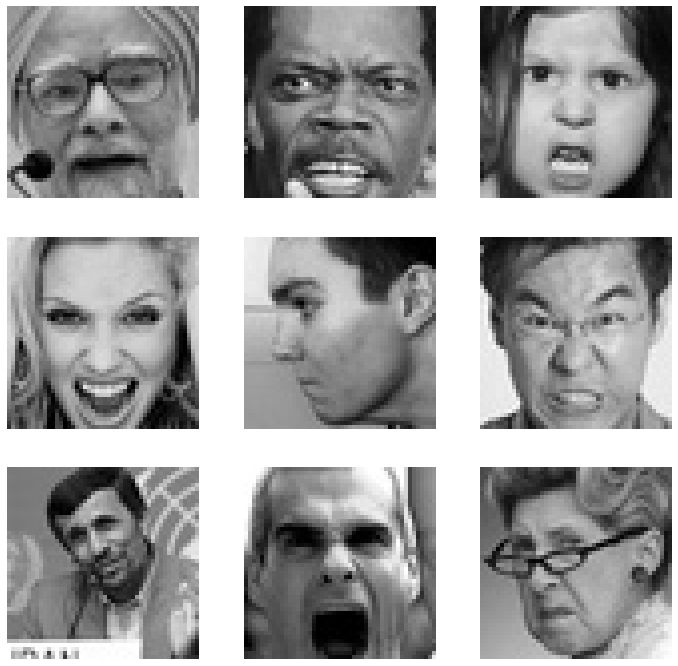

In [ ]:
#Visualizing the Images of different classes

def plot_images(expression, picture_size, folder_path):
  plt.figure(figsize= (12,12))
  for i in range(1, 10, 1):
      plt.subplot(3,3,i)
      img = load_img(folder_path + "train/" + expression + "/" +
                    os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
      plt.axis("off")
      plt.imshow(img)   
  
  plt.show()

plot_images(EXPRESSION, PICTURE_SIZE, FOLDER_PATH)

#**Image Generators**

In [ ]:
#Creating Image Generators for Train and Validation Data

datagen_train = ImageDataGenerator(horizontal_flip=True)

datagen_valid = ImageDataGenerator(horizontal_flip=True)


train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (PICTURE_SIZE,PICTURE_SIZE),
                                              color_mode = "grayscale",
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'categorical',
                                              shuffle = True)


valid_set = datagen_valid.flow_from_directory(folder_path + "validation",
                                              target_size = (PICTURE_SIZE,PICTURE_SIZE),
                                              color_mode = "grayscale",
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'categorical',
                                              shuffle = False)

Found 24282 images belonging to 5 classes.
Found 5937 images belonging to 5 classes.


In [ ]:
valid_set.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [ ]:
valid_set.class_indices.keys()

dict_keys(['angry', 'happy', 'neutral', 'sad', 'surprise'])

#**Model**

###**Architecture**

In [ ]:
#Defining the Model Architecture

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation = 'softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

###**Compile**

In [ ]:
#Defining callbacks for better training

checkpoint = ModelCheckpoint("/content/drive/MyDrive/Face_Physiognomy/best_model.h5", monitor = 'val_accuracy', verbose = 1, 
                             save_best_only = True, mode = 'max')

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                              factor = 0.2,
                              patience = 6,
                              verbose = 1,
                              min_delta = 0.00001)

callbacks_list = [PlotLossesKerasTF(), checkpoint,reduce_learning_rate]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.0005),
              metrics=['accuracy'])

###**Train**

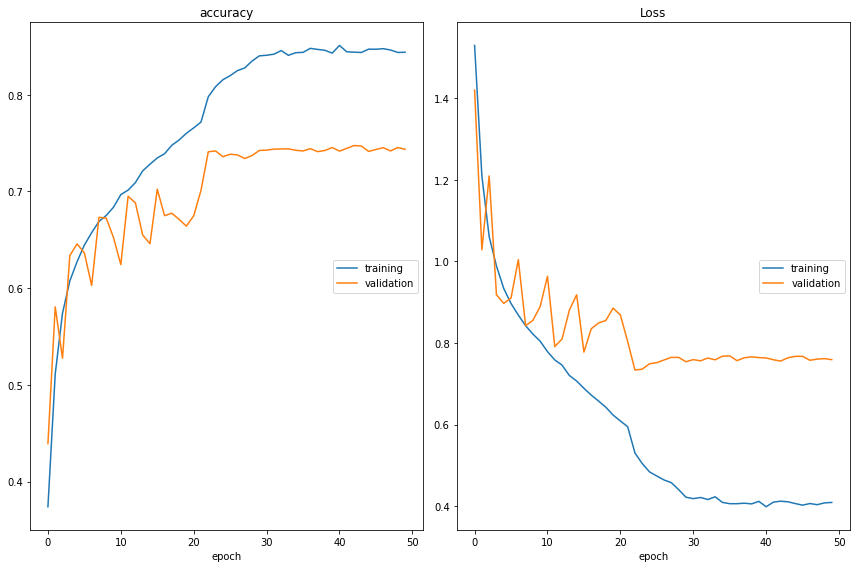

accuracy
	training         	 (min:    0.374, max:    0.851, cur:    0.844)
	validation       	 (min:    0.439, max:    0.747, cur:    0.744)
Loss
	training         	 (min:    0.399, max:    1.529, cur:    0.410)
	validation       	 (min:    0.734, max:    1.419, cur:    0.759)

Epoch 50: val_accuracy did not improve from 0.74745
379/379 [==============================] - 43s 113ms/step - loss: 0.4096 - accuracy: 0.8439 - val_loss: 0.7593 - val_accuracy: 0.7435 - lr: 1.6000e-07


In [ ]:
#Training the Model

history = model.fit_generator(generator = train_set,
                              steps_per_epoch = train_set.n // train_set.batch_size,
                              epochs = epochs,
                              validation_data = valid_set,
                              validation_steps = valid_set.n // valid_set.batch_size,
                              callbacks = callbacks_list)

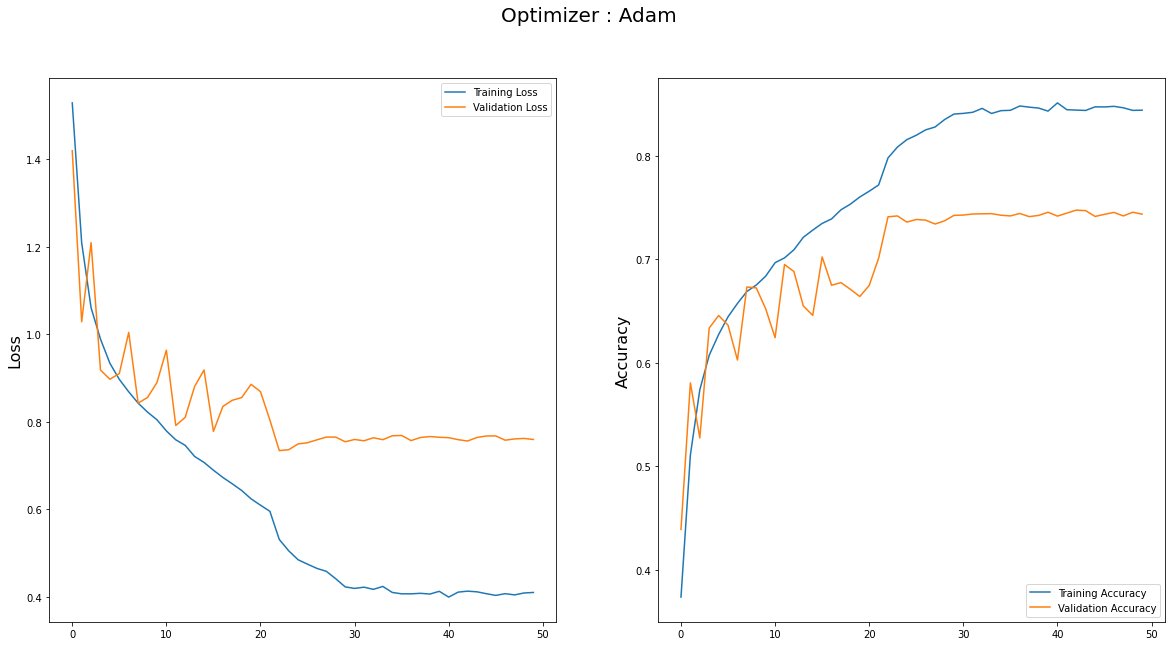

In [ ]:
#Plotting the Loss and Accuracy 

plt.figure(figsize = (20,10))

plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize = 20)
plt.ylabel('Loss', fontsize = 16)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend(loc = 'upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize = 16)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.show()

#**Visualizing Results and Reports**

In [ ]:
model.evaluate(valid_set)

93/93 [==============================] - 8s 87ms/step - loss: 0.7668 - accuracy: 0.7458


[0.7667620778083801, 0.7458312511444092]

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff


test_steps_per_epoch = np.math.ceil(valid_set.samples / valid_set.batch_size)
predictions = model.predict(valid_set, steps=test_steps_per_epoch)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = valid_set.classes
class_labels = list(valid_set.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)   

cm = confusion_matrix(true_classes,predicted_classes)

x = ['angry', 'happy', 'neutral', 'sad', 'surprise']
y = ['surprise', 'sad', 'neutral', 'happy', 'angry']

# change each element of cm to type string for annotations
z_text = [[str(round(y/len(predictions)*100, 2)) + '%' for y in x] for x in cm]

# set up figure 
fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  # xaxis = dict(title='x'),
                  yaxis = dict(title='Real Class')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted Class",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()

              precision    recall  f1-score   support

       angry       0.70      0.61      0.65       960
       happy       0.87      0.87      0.87      1825
     neutral       0.65      0.69      0.67      1216
         sad       0.63      0.64      0.63      1139
    surprise       0.85      0.85      0.85       797

    accuracy                           0.74      5937
   macro avg       0.74      0.73      0.73      5937
weighted avg       0.75      0.74      0.74      5937



#**Inferencing**

In [ ]:
# Load Model Architecture

with open('/content/model.json', 'r') as json_file:
    json_savedModel= json_file.read()

model_j = tf.keras.models.model_from_json(json_savedModel)
model_j.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [ ]:
#Load Model Weights

model_j.load_weights('/content/drive/MyDrive/Face_Physiognomy/best_model.h5')

(533, 800)
happy


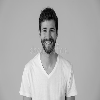

In [ ]:
# Inferencing

from google. colab. patches import cv2_imshow
import cv2

c = {0:'angry', 1:'happy', 2:'neutral', 3:'sad', 4:'surprise'}

img = cv2.imread('/content/happy.jpg', 0)
img_display = cv2.resize(img, (100,100))
print(img.shape)

faceCascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
faces = faceCascade.detectMultiScale(img, 1.3, 5)
       
for (x, y, w, h) in faces: 
  fc = img[y:y+h, x:x+w]
  roi = cv2.resize(fc, (48, 48))
  roi = roi.reshape(1,48,48,1)
  x = np.argmax(model_j.predict(roi))

print(c.get(x))
cv2_imshow(img_display)

['/content/drive/MyDrive/Face_Physiognomy/Validate/S133_003_00000047.png', '/content/drive/MyDrive/Face_Physiognomy/Validate/S127_010_00000018.png', '/content/drive/MyDrive/Face_Physiognomy/Validate/S056_004_00000020.png', '/content/drive/MyDrive/Face_Physiognomy/Validate/S055_005_00000045.png', '/content/drive/MyDrive/Face_Physiognomy/Validate/S093_001_00000020.png', '/content/drive/MyDrive/Face_Physiognomy/Validate/S056_003_00000010.png', '/content/drive/MyDrive/Face_Physiognomy/Validate/S055_001_00000012.png', '/content/drive/MyDrive/Face_Physiognomy/Validate/S014_002_00000016.png', '/content/drive/MyDrive/Face_Physiognomy/Validate/S032_006_00000016.png', '/content/drive/MyDrive/Face_Physiognomy/Validate/S053_001_00000023.png', '/content/drive/MyDrive/Face_Physiognomy/Validate/S014_001_00000001.png', '/content/drive/MyDrive/Face_Physiognomy/Validate/S005_001_00000001.png']
(490, 640)
angry


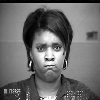

(490, 640)
angry


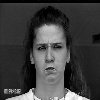

(490, 640)
happy


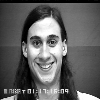

(490, 640)
happy


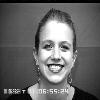

(490, 640)
sad


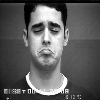

(490, 640)
surprise


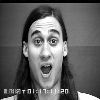

(490, 640)
surprise


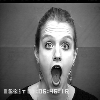

(490, 640)
sad


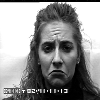

(490, 640)
happy


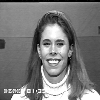

(490, 640)
surprise


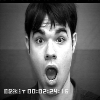

(490, 640)
neutral


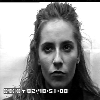

(490, 640)
neutral


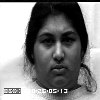

In [ ]:
import glob
files = glob.glob("/content/drive/MyDrive/Face_Physiognomy/Validate/*")
print(files)

for f in files:
  img = cv2.imread(f, 0)
  img_display = cv2.resize(img, (100,100))
  print(img.shape)

  faceCascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
  faces = faceCascade.detectMultiScale(img, 1.3, 5)
        
  for (x, y, w, h) in faces: 
    fc = img[y:y+h, x:x+w]
    roi = cv2.resize(fc, (48, 48))
    roi = roi.reshape(1,48,48,1)
    x = np.argmax(model_j.predict(roi))

  print(c.get(x))
  cv2_imshow(img_display)


In [ ]:
# Save Model Architecture

tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)